In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Input, concatenate, UpSampling2D, Activation
from tensorflow.keras.applications import VGG16, vgg16, ResNet50
import tensorflow.keras.backend as kb

import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2
import scipy.io
from skimage import color
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.transform import resize

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
_, (X_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [27]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Predictions'
X_baseline_orig = np.load(os.path.join(PATH, 'deep_classification_norebal81.npy'))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_test_orig, y_test_orig, test_size=0.20, random_state=35)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train = X_train
X_test = X_test

(8000, 32, 32, 3) (2000, 32, 32, 3) (8000, 1) (2000, 1)


In [28]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [29]:
X_train = X_train / 255
X_test = X_test / 255

In [30]:
from keras.utils import np_utils

y_train = (np_utils.to_categorical(y_train, 10) / 255) * 255
y_test = (np_utils.to_categorical(y_test, 10) / 255) * 255

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


TypeError: ignored

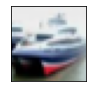

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_test[i][0]])

fig.tight_layout()  
plt.subplots_adjust(top=.94)
fig.suptitle('Ground Truth', fontsize=16)
plt.show()

In [ ]:
def classify(img_shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=img_shape))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(100))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [ ]:
with tf.device('/device:GPU:0'):
  PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models/Eval Classification'
  MODEL_TYPE = 'best_classification'

  model = classify((32,32,3))

  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
  
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PATH, f"{MODEL_TYPE}.h5"),
                                                  overwrite=True, save_weights_only=False, 
                                                  monitor='val_loss', mode='min', save_best_only=True)
  
  callbacks = [early, checkpoint]

  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  # datagen.fit(X_train)

  # Fit the model on the batches generated by datagen.flow().
  # history = model.fit_generator(datagen.flow(X_train, y_train,
  #                                 batch_size=1024),
  #                     epochs=100,
  #                     validation_data=(X_test, y_test), callbacks=[callbacks])

  history = model.fit(X_train, y_train,
              epochs=150, verbose=2,
              validation_data=(X_test, y_test), batch_size=128, shuffle=True, callbacks=[callbacks])

Epoch 1/150
391/391 - 4s - loss: 1.7193 - accuracy: 0.3667 - val_loss: 1.4336 - val_accuracy: 0.4924
Epoch 2/150
391/391 - 3s - loss: 1.3425 - accuracy: 0.5205 - val_loss: 1.1206 - val_accuracy: 0.6031
Epoch 3/150
391/391 - 3s - loss: 1.1620 - accuracy: 0.5886 - val_loss: 0.9617 - val_accuracy: 0.6581
Epoch 4/150
391/391 - 3s - loss: 1.0454 - accuracy: 0.6330 - val_loss: 0.8776 - val_accuracy: 0.6919
Epoch 5/150
391/391 - 3s - loss: 0.9660 - accuracy: 0.6624 - val_loss: 0.8322 - val_accuracy: 0.7145
Epoch 6/150
391/391 - 3s - loss: 0.9066 - accuracy: 0.6846 - val_loss: 0.8127 - val_accuracy: 0.7178
Epoch 7/150
391/391 - 3s - loss: 0.8585 - accuracy: 0.7010 - val_loss: 0.7715 - val_accuracy: 0.7302
Epoch 8/150
391/391 - 3s - loss: 0.8152 - accuracy: 0.7174 - val_loss: 0.7278 - val_accuracy: 0.7451
Epoch 9/150
391/391 - 3s - loss: 0.7828 - accuracy: 0.7258 - val_loss: 0.7060 - val_accuracy: 0.7527
Epoch 10/150
391/391 - 3s - loss: 0.7498 - accuracy: 0.7386 - val_loss: 0.6948 - val_accura

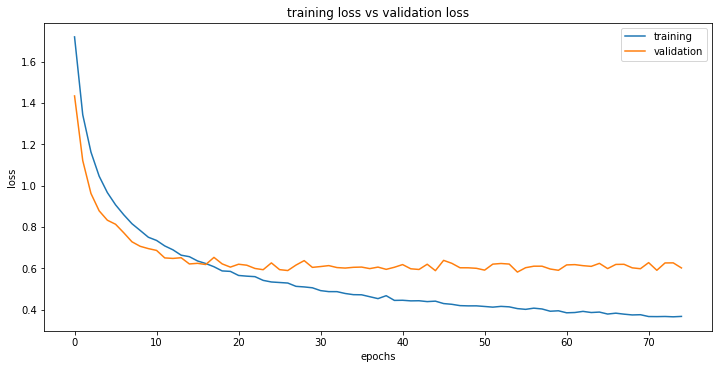

In [ ]:
model_history(history, 10)

In [50]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Predictions'
X_test = np.load(os.path.join(PATH, 'classification_vgg_unlearnable_norebal81.npy'))

In [23]:
row_max = np.max(X_test)
row_min = np.min(X_test)
# print(row_max)

print(row_max.shape)

X_test = (X_test - row_min) / (row_max - row_min)

()


In [44]:
print(np.max(X_test))

1.0


In [ ]:
X_test = np.stack((X_test[:,:,:,0],)*3, axis=-1)

In [51]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models/Eval Classification'
MODEL_TYPE = 'best_classification'

model = tf.keras.models.load_model(os.path.join(PATH, MODEL_TYPE) + '.h5')

model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8217 - accuracy: 0.7694


[0.8216716051101685, 0.7694000005722046]

In [ ]:
def __display_training_curves(training, validation, subplot):
    """
    summary: helper function for plotting the model history
    """
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('training loss vs validation loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend(['training', 'validation'])

def model_history(history, size=10):
    """
    history: {history} tensorflow history object
    size: {size} size of viewing window

    summary: plots the model history (training vs. validation loss)
    """
    plt.subplots(figsize=(size, size))
    plt.tight_layout()
    __display_training_curves(history.history['loss'], history.history['val_loss'], 211)